In [1]:
import numpy as np
import matplotlib.pyplot as plt

### To do:
- Plot results inside class
- plot MFD inside class
- plot path travel time
- plot instaneous path ratio
- Implement a greedy controller
- Try with a differeent network
- Implement cost function (see cost function at the end of the simulation)
- Implement two player game

Later:
- Implement cars with probabilities
- Try on Fremont network
- Do optimal control


In [2]:
class network:
    def __init__(self, graph_dict):
        def create_connections(g):
            connections = np.zeros((1,2))
            for i in self.graph.keys():
                for j in self.graph[i]["connection"]:
                    connections = np.append(connections, [[i, j],], axis=0)
            connections = connections[1:]
            return connections
        
        def create_adj_line_graph(array):
            nb_links = array.shape[0]
            adj_matrix = np.zeros((nb_links,nb_links))
            for k in range(nb_links):
                adj_matrix[k][np.argwhere(array[:,0]==array[k][1])] = 1
            return adj_matrix
        
        # This dictionary is the graph
        self.graph = graph_dict
        self.connections = create_connections(self.graph)
        self.nb_links = self.connections.shape[0]
        self.__adj_matrix = create_adj_line_graph(self.connections)
        self.__mfd_set_up = False
        
    def get_adj_matrix(self):
        return self.__adj_matrix.copy()

    def set_up_mfd(self, v_max, x_max, c):
        if not (self.is_valid_flow(x_max) & self.is_valid_flow(x_max) & self.is_valid_flow(x_max)):
            print("Incorrect vectors to set up to MFD")
            pass
        self.v_max = v_max
        self.x_max = x_max
        self.c = c
        self.__mfd_set_up = True

    def is_valid_flow(self, x):
        if not isinstance(x, np.ndarray):
            return False
        return (x.size == self.nb_links) & (x >= 0).all()
    
    def is_valid_matrix(self, P):
        # P should be an array
        if not isinstance(P, np.ndarray):
            return False
        
        # P should has the same size as the graph
        if not P.shape == self.__adj_matrix.shape:
            return False
        
        # P should has 0 where adj_matrix has 0
        if not np.all(P[self.__adj_matrix == 0]==0):
            return False
        
        # element of P should be >=0
        if not np.all(P>=0):
            return False
        return True
    
    def is_valid_matrix_with_destination(self, P, destination):
        if not self.is_valid_matrix(P):
            return False
        for i in range(self.nb_links):
            if not i in destination:
                if np.sum(P[i,:])!=1:
                    return False
        return True
    
    def is_valid_outflow_ratio(self, x):
        if not isinstance(x, np.ndarray):
            return False
        return (x.size == self.nb_links) & (x >= 0).all() & (x <= 1).all()
    
    def update_matrix_from_with_mfd(self, mfd_v, P, des):
        if not (self.is_valid_outflow_ratio(mfd_v) and self.is_valid_matrix_with_destination(P, des)):
            print("Matrix or vector of travel time are not correct")
            return -1
        matrix = - np.diag(np.ones(self.nb_links))
        for i in range(self.nb_links):
            matrix[i,:] = (matrix[i,:] + P[i,:]) * mfd_v[i]
        return matrix

    def mfd_aux(self,x, v_max, x_max, c):
        if x == 0 or x >= xmax:
            return 0
        v = v_max*(1-np.exp((c/v_max) * (1-x_max/x)))
        return v
    
    def mfd(self,x, v_max, x_max, c):
        return x * self.mfd_aux(x, v_max, x_max, c)
        
    def get_mean_travel_time(self, x):
        if not self.__mfd_set_up:
            print("Please use set up MFD function before running the experiment")
            return
        tt = np.zeros(self.nb_links)
        for i in range(self.nb_links):
            mfd_tmp = self.mfd_aux(x[i], self.v_max[i], self.x_max[i], self.c[i])
            if mfd_tmp == 0:
                tt[i] = 10**6
            else:
                tt[i] = 1/mfd_tmp
        return tt
        
    def update_flow_from_matrix_one_player(self, x, P, dt, des=-1):
        if not self.__mfd_set_up:
            print("Please use set up MFD function before running the experiment")
            return
        if not self.is_valid_flow(x):
            print("Flow vector x does not seems correctly defined")
            return
        if not self.is_valid_matrix_with_destination(P, des):
            print("P does not seems to be a correct control matrix")
            return
        mfd_v = np.array([self.mfd_aux(x[i], self.v_max[i], self.x_max[i], self.c[i]) for i in range(self.nb_links)])
        matrix = self.update_matrix_from_with_mfd(mfd_v, P, des)
        x_t_1 = x + matrix.T @ x * dt
        return x_t_1
    
    def plot_network(self):
        links = np.zeros((self.nb_links, 4))
        for i in range(self.nb_links):
            links[i,:2] = self.graph[self.connections[i,0]]["location"]
            links[i,2:] = self.graph[self.connections[i,1]]["location"]
    
        plt.quiver(links[:, 0], links[:, 1], links[:, 2]-links[:, 0], links[:, 3]-links[:, 1], color="b", angles='xy', scale_units='xy', scale=1)
        plt.xlim([np.min(links[:, [0,2]])-0.5, np.max(links[:, [0,2]]) + 0.5])
        plt.ylim([np.min(links[:, [1,3]])-0.5, np.max(links[:, [1,3]]) + 0.5])
        plt.show()
        
    def simulation_one_player(self, x0, nb_iteration, dt, controller, destination):
        x = x0
        # saving the results
        f = np.zeros((nb_iteration+1, g.nb_links))
        for t in range(nb_iteration):
            f[t] = x
            x = self.update_flow_from_matrix_one_player(x, controller(self, x), dt, destination)
        f[nb_iteration] = x
        return f


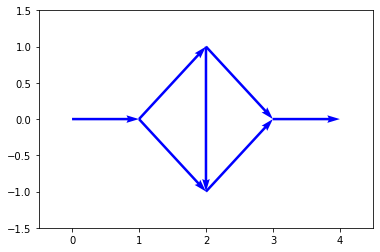

In [3]:
# Maybe we can set up the MFD in the dictionary
# creating the graph
graph_dict = {0: {"connection": {1}, "location": [0, 0]},
                      1: {"connection": {2, 3}, "location": [1, 0]},
                      2: {"connection": {3, 4}, "location": [2, 1]},
                      3: {"connection": {4}, "location": [2, -1]},
                      4: {"connection": {5}, "location": [3, 0]},
                      5: {"connection": {}, "location": [4, 0]}}
g = network(graph_dict)
g.plot_network()


In [4]:
# Creating the MFD
vmax = 0.3 # 1/number of iteration to exit the link under free flow
xmax = 100 # max flow rate
c = 0.2

vmax_array = vmax * np.ones(g.nb_links)
xmax_array = xmax * np.ones(g.nb_links)
c_array = c * np.ones(g.nb_links)

# all vehicle should exist the network at the 
vmax_array[0] = 1
xmax_array[0] = 1000
c_array[0] = 1000
c_array[g.nb_links-1] = 0
g.set_up_mfd(vmax_array, xmax_array, c_array)

In [5]:
# create a dummy controller
def controller_matrix(g, x):
    u1 = 0.5
    u2 = 0.1
    matrix = g.get_adj_matrix()
    matrix[0][1] = 1 - u1
    matrix[0][2] = u1
    matrix[1][3] = 1 - u2
    matrix[1][4] = u2
    return matrix
## TO DO -> get controller using instantaneous travel time using scipy.csc_matrix 

# Setting up the simulation
x = np.zeros(g.nb_links)
x[0] = 50
nb_iteration = 300
time_step = 0.1

f = g.simulation_one_player(x, nb_iteration, time_step, controller_matrix, [6])

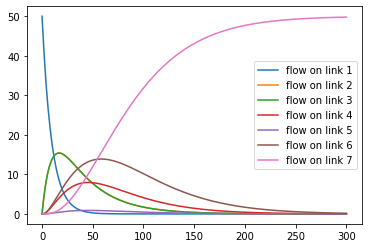

In [6]:
plt.plot(f[:,0], label="flow on link 1")
plt.plot(f[:,1], label="flow on link 2")
plt.plot(f[:,2], label="flow on link 3")
plt.plot(f[:,3], label="flow on link 4")
plt.plot(f[:,4], label="flow on link 5")
plt.plot(f[:,5], label="flow on link 6")
plt.plot(f[:,6], label="flow on link 7")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


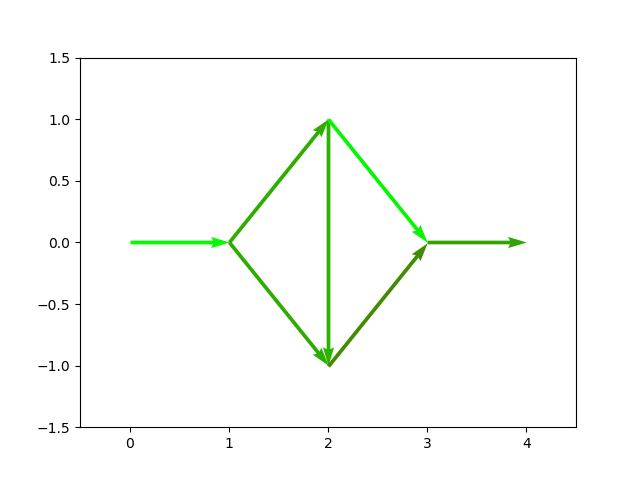

In [7]:
# showing the simulation
%matplotlib notebook
import matplotlib.animation as animation

links = np.zeros((g.nb_links, 4))
for i in range(g.nb_links):
    links[i,:2] = g.graph[g.connections[i,0]]["location"]
    links[i,2:] = g.graph[g.connections[i,1]]["location"]


cdict = {'red': (1.0, 0.0, 0.0), 'green': (0.0, 1.0, 0.0)}

fig, ax = plt.subplots()
ln = []
for i in range(g.nb_links):
    ln.append(plt.quiver(links[i, 0], links[i, 1], links[i, 2]-links[i, 0], links[i, 3]-links[i, 1], color="b", angles='xy', scale_units='xy', scale=1))
plt.xlim([-0.5, 4.5])
plt.ylim([-1.5, 1.5])

def init():
#     ax.set_xlim(0, 5)
#     ax.set_ylim(-1.5, 1.5)
    return ln,

def update(frame):
    c = np.array([(1-f[frame]/50)**2 * cdict["green"][i] + (f[frame]/50) * cdict["red"][i] for i in range(3)]).T
    for i in range(7):
        ln[i].set_color(c[i])
    return ln,

ani = animation.FuncAnimation(fig, update, frames= 200,
                    init_func=init, blit=True)
plt.show()

# # Set up formatting for the movie files
# Writer = animation.writers['ffmpeg']
# writer = Writer(fps=5, metadata=dict(artist='Me'), bitrate=600)

# ani.save('test_simulation_2.mp4', writer=writer)


In [ ]:
print(g.is_valid_flow(np.ones(g.nb_links)))

In [ ]:
def mfd_aux(x, v_max, x_max, c):
    if x == 0 or x >= xmax:
        return 0
    v = v_max*(1-np.exp((c/v_max) * (1-x_max/x)))
    return v

vmax = 1 # 1/number of iteration to exit the link under free flow
xmax = 1000 # max flow rate
c = 1000 # ??

x_dot = [mfd_aux(x+1, vmax, xmax, c) for x in range(100)]

print([vmax*(1 - np.exp((c/vmax) * (1-xmax/(x+1)))) for x in range(100)])
# print(x_dot)
plt.plot([vmax*(1 - np.exp((c/vmax) * (1-xmax/(x+1)))) for x in range(100)])
plt.plot(x_dot)
plt.show()

print(np.argmax(x_dot))